# RTF Model for predicting racket type using P1, P2 and P3, based on peaks features - Sound

### Model Description

This notebook implements a Random Tree Forest (RTF) model to predict the type of a racket (RB, RO, RR, RV) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting frequency peaks using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and confusion matrices.

### Import libraries

In [ ]:
import os
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

### Import Tools Functions

In [ ]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

In [ ]:
# Import functions

from extractPeakFromSignal import extractPeakFromSignal
from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
from spectrumFromWav import spectrumFromWav

### Example

['P1_RB_1_C_1.wav', 'P1_RB_1_C_2.wav', 'P1_RB_1_C_3.wav', 'P1_RB_1_S_1.wav', 'P1_RB_1_S_2.wav', 'P1_RB_1_S_3.wav', 'P1_RB_1_V_1.wav', 'P1_RB_1_V_2.wav', 'P1_RB_1_V_3.wav', 'P1_RB_2_C_1.wav', 'P1_RB_2_C_2.wav', 'P1_RB_2_C_3.wav', 'P1_RB_2_S_1.wav', 'P1_RB_2_S_2.wav', 'P1_RB_2_S_3.wav', 'P1_RB_2_V_1.wav', 'P1_RB_2_V_2.wav', 'P1_RB_2_V_3.wav', 'P1_RB_3_C_1.wav', 'P1_RB_3_C_2.wav', 'P1_RB_3_C_3.wav', 'P1_RB_3_S_1.wav', 'P1_RB_3_S_2.wav', 'P1_RB_3_S_3.wav', 'P1_RB_3_V_1.wav', 'P1_RB_3_V_2.wav', 'P1_RB_3_V_3.wav', 'P1_RB_4_C_1.wav', 'P1_RB_4_C_2.wav', 'P1_RB_4_C_3.wav', 'P1_RB_4_S_1.wav', 'P1_RB_4_S_2.wav', 'P1_RB_4_S_3.wav', 'P1_RB_4_V_1.wav', 'P1_RB_4_V_2.wav', 'P1_RB_4_V_3.wav', 'P1_RB_5_C_1.wav', 'P1_RB_5_C_2.wav', 'P1_RB_5_C_3.wav', 'P1_RB_5_S_1.wav', 'P1_RB_5_S_2.wav', 'P1_RB_5_S_3.wav', 'P1_RB_5_V_1.wav', 'P1_RB_5_V_2.wav', 'P1_RB_5_V_3.wav', 'P1_RB_6_C_1.wav', 'P1_RB_6_C_2.wav', 'P1_RB_6_C_3.wav', 'P1_RB_6_S_1.wav', 'P1_RB_6_S_2.wav', 'P1_RB_6_S_3.wav', 'P1_RB_6_V_1.wav', 'P1_RB_6_V_

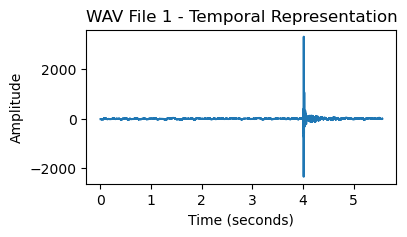

In [ ]:
samplerateVect,testWavFileVect,filename = readWavFolder("../../../Data/Sound/P1")
print(filename)

for i, wav_data in enumerate(testWavFileVect[:1]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 0])  # Plot only the first channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

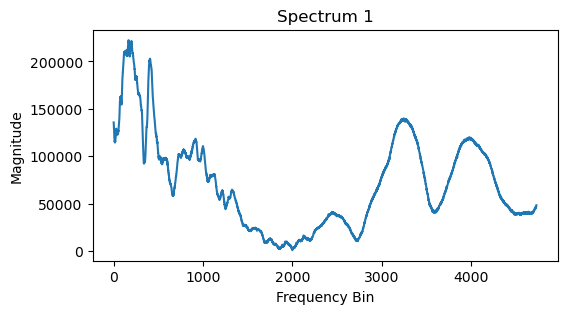

In [ ]:
spectrumVect=[]
for i in range(len(testWavFileVect)):
    spectrum = spectrumFromWav(testWavFileVect[i])
    freqs = np.fft.fftfreq(len(spectrum) * 2, d=1/samplerateVect[i])[:len(spectrum)]
    filtered_spectrum = spectrum[(freqs >= 150) & (freqs <= 1000)]
    spectrumVect.append(filtered_spectrum)

plt.figure(figsize=(6, 3))
plt.plot(spectrumVect[0])
plt.title(f"Spectrum 1")
plt.xlabel("Frequency Bin")
plt.ylabel("Magnitude")
plt.show()

## Main

In [ ]:
# List of raquette types
raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}

# List to store the results
results = []

for n_peak in range(5, 101, 5):

    X_peaksHz = []
    X_peaksAmplitude = []
    Y_Label = []
    #print("Nbr_peak", n_peak)

    # Create a DataFrame to store details of each wav file
    wav_files_data = []

    # Process each folder (P1, P2, P3)
    for folder, folder_path in [("P1", "../../../Data/Sound/P1"), 
                                ("P2", "../../../Data/Sound/P2"), 
                                ("P3", "../../../Data/Sound/P3")]:
        sample_rates, wav_files, file_names = readWavFolder(folder_path)
        
        for sample_rate, wav_file, file_name in zip(sample_rates, wav_files, file_names):
            wav_files_data.append({
                "Folder": folder,
                "File_Name": file_name,
                "Sample_Rate": sample_rate,
                "Signal": wav_file
            })

    # Convert the list of dictionaries into a DataFrame
    wav_files_df = pd.DataFrame(wav_files_data)

    # Display the DataFrame
    #print(wav_files_df)

    spectrumVect=[]

    # For each wav file, extract its spectrum, filter it between 150 and 1000 Hz, and take the n best peaks
    for i in range(len(wav_files_df["Signal"])):
        if "C" in wav_files_df["File_Name"][i]:
            if 'RB' in wav_files_df["File_Name"][i]:
                raquetteType = 'RB'
            elif 'RR' in wav_files_df["File_Name"][i]:
                raquetteType = 'RR'
            elif 'RO' in wav_files_df["File_Name"][i]:
                raquetteType = 'RO'
            elif 'RV' in wav_files_df["File_Name"][i]:
                raquetteType = 'RV'

            # Extract the spectrum from the wav file
            spectrum, freqs = spectrumFromSignal(wav_files_df["Signal"][i], wav_files_df["Sample_Rate"][i])
            spectrumVect.append(freqs)

            # Peak extraction
            peaks, peak_values = extractPeakFromSignal(signal=spectrum, num_peaks=n_peak)

            X_peaksHz.append(peaks)
            X_peaksAmplitude.append(peak_values["peak_heights"])

            Y_Label.append(raquetteType)

    # Normalize the amplitudes
    X_peaksAmplitude = [peak_values / np.max(peak_values) for peak_values in X_peaksAmplitude]

    # Ensure all arrays in X_peaksHz and X_peaksAmplitude have the same length
    max_length = max(max(len(peaks) for peaks in X_peaksHz), max(len(amps) for amps in X_peaksAmplitude))
    X_peaksHz_padded = [np.pad(peaks, (0, max_length - len(peaks)), constant_values=0) for peaks in X_peaksHz]
    X_peaksAmplitude_padded = [np.pad(amps, (0, max_length - len(amps)), constant_values=0) for amps in X_peaksAmplitude]

In [ ]:
# Combine the frequencies and amplitudes into a single feature matrix
X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [ ]:
# Random Forest algorithm parameters
n_estimators_range = range(10, 101, 10)  # Number of trees between 10 and 100
max_depth_range = [None, 10, 20, 30, 40]  # Different depths
min_samples_split_range = [2, 5, 10]  # Minimum number to divide a node
min_samples_leaf_range = [1, 2, 4]  # Minimum number of samples in a sheet
max_features_range = ['sqrt', 'log2', None]  # Number of features per tree

# Test all the combinations of parameters
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            # Create and train the Random Forest model
            rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                        min_samples_split=min_samples_split, random_state=42)
            rf.fit(X_train, y_train)

            # Evaluate on the test set
            y_pred = rf.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Evaluate on the training set
            y_train_pred = rf.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Add the results to the list
            results.append({
                'nbr_de_peak': n_peak,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results by accuracy_test in descending order
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

print(sorted_results_df)

# Register the best parameters in a CSV file
sorted_results_df.to_csv("S_RTF_Racket_P1.P2.P3_Peaks.csv", index=False)

print("Results have been saved to 'S_RTF_Racket_P1.P2.P3_Peaks.csv'.")

    nbr_de_peak  n_estimators  max_depth  min_samples_split  accuracy_train  \
75          100            60        NaN                  2        1.000000   
84          100            60       30.0                  2        1.000000   
81          100            60       20.0                  2        1.000000   
85          100            60       30.0                  5        0.993724   
87          100            60       40.0                  2        1.000000   
..          ...           ...        ...                ...             ...   
7           100            10       20.0                  5        0.976987   
1           100            10        NaN                  5        0.976987   
22          100            20       20.0                  5        0.983264   
3           100            10       10.0                  2        0.983264   
18          100            20       10.0                  2        0.989540   

    accuracy_test  
75       0.716667  
84       0.